# Project 3: Adversarial Attacks

**Name**: Nikhil Arora & Devanshi Bhavsar  
**Net id**: na4063 & dnb7638  
**Course**: Deep Learning CS-GY 6953/ ECE-GY 7123 – Spring 2025  


## Setup & Configuration

In this cell we:
- import all required libraries  
- set seeds for full reproducibility  
- configure device (CPU/GPU) and CuDNN  
- define paths and all of our hyperparameters  


In [1]:
import os, random, time, json, gc
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import models, datasets
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ─── Reproducibility ───────────────────────────────────────────────────────────
seed = 2025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# make CuDNN deterministic (at a slight speed cost)
cudnn.deterministic = True
cudnn.benchmark     = False

# ─── Device ─────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ─── Paths & Hyperparameters ───────────────────────────────────────────────────
dataset_path = "/kaggle/input/dl-3-testdataset/TestDataSet"
assert os.path.isdir(dataset_path), f"{dataset_path} not found"

config = {
    "batch_size":    32,     # how many images per batch
    "epsilon_fgsm":  0.02,   # FGSM perturbation magnitude (pixel space)
    "pgd_alpha":     0.004,  # PGD step‐size (pixel space)
    "pgd_steps":     10,     # number of PGD iterations
    "patch_size":    32,     # side-length of square patch
    "patch_eps":     0.3,    # max‐norm for patch attack (pixel space)
    "num_workers":   0,      # DataLoader workers
    # separate PGD budget & step‐size for DenseNet transfer experiments
    "pgd_eps_dn":    0.02,
    "pgd_alpha_dn":  0.004,
}


Using device: cuda


## Transforms & Label Mappings

In this cell we:

1. **Load pretrained weights & build our transform pipeline**  
2. **Download and parse the ImageNet class‐index JSON** to map synset strings → global indices (0–999)  
3. **Load our 100-image human subset labels** and map them into the global indexing (401–500)  
4. **Define a DataLoader factory** that remaps each folder name (synset) to its global ImageNet index  
5. Run a quick **sanity check** to verify that everything is wired up correctly  


In [2]:
# Pretrained weights & transform pipeline
weights   = models.ResNet34_Weights.IMAGENET1K_V1    # pick the ResNet-34 ImageNet weights
transform = weights.transforms()                     # built-in preprocess: resize, center-crop, normalize

# Download official ImageNet class-index JSON
if not os.path.exists("imagenet_class_index.json"):
    get_ipython().system(
        "wget -q https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
    )
with open("imagenet_class_index.json") as f:
    class_idx     = json.load(f)                    # mapping "0": ["n01440764","tench"], ...
synset_to_i = {v[0]: int(k) for k, v in class_idx.items()}  # synset string → global idx
idx_to_name = {int(k): v[1]     for k, v in class_idx.items()}  # global idx → human-readable name

# Load our 100-image human subset labels → global indexing (401…500)
with open(os.path.join(dataset_path, "labels_list.json")) as f:
    human100 = [s.split(":",1)[1].strip() for s in json.load(f)]
idx100_to_name = {401 + i: name for i, name in enumerate(human100)}

# DataLoader factory that remaps folder synsets → global ImageNet idx
def get_loader(path, batch_size=None):
    bs = batch_size or config["batch_size"]
    ds = datasets.ImageFolder(path, transform=transform)
    # remap each sample's folder-based label to the global ImageNet index
    new_samples = []
    for img_path, local_idx in ds.samples:
        syn = ds.classes[local_idx]          # e.g. "n02672831"
        gi  = synset_to_i[syn]               # e.g. 401…500
        new_samples.append((img_path, gi))
    ds.samples = new_samples
    ds.targets = [lbl for _, lbl in new_samples]
    return DataLoader(
        ds,
        batch_size=bs,
        shuffle=False,
        num_workers=config["num_workers"],
    )

# Sanity check: load a small batch and print shapes & labels
loader = get_loader(dataset_path, batch_size=4)
imgs, lbls = next(iter(loader))
print("Batch shape:", imgs.shape, "→ labels:", lbls)


Batch shape: torch.Size([4, 3, 224, 224]) → labels: tensor([401, 401, 401, 401])


## Evaluation Function

In this cell we define a reusable `evaluate()` helper that:

1. Switches the model into evaluation mode (`model.eval()`) and disables gradient computation.  
2. Iterates over the provided DataLoader, moving inputs and labels to the chosen device.  
3. Computes raw logits and extracts:
   - **Top-1** predictions via `argmax`
   - **Top-5** predictions via `logits.topk(5)`  
4. Accumulates correct counts for both metrics and divides by the total number of samples to return percentages.

This utility will be used throughout Tasks 1–5 to report clean and adversarial accuracies.


In [3]:
def evaluate(model, loader):
    model.eval()                  # set model to evaluation mode
    total, c1, c5 = 0, 0, 0       # counters: total samples, top-1 correct, top-5 correct
    with torch.no_grad():         # disable gradient computation
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)

            # Top-1 accuracy
            p1 = logits.argmax(dim=1)
            c1 += (p1 == y).sum().item()

            # Top-5 accuracy
            top5 = logits.topk(5, dim=1)[1]
            for i in range(y.size(0)):
                if y[i] in top5[i]:
                    c5 += 1

            total += X.size(0)

    # convert counts to percentages
    return 100 * c1 / total, 100 * c5 / total

## Task 1 — Baseline on Clean Test Set

In this cell we:

1. **Load the pretrained ResNet-34** and create the test DataLoader.  
2. **Compute quantitative performance** (Top-1 and Top-5 accuracy).  
3. **Show 3 qualitative examples**: each clean image alongside its Top-5 predictions with confidences.  
4. **Compute per-class accuracy** over the 100-image subset and print the five easiest and hardest classes.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s] 


[Task 1] Clean Top-1: 70.40%, Top-5: 93.20%  (Time: 7.1s)


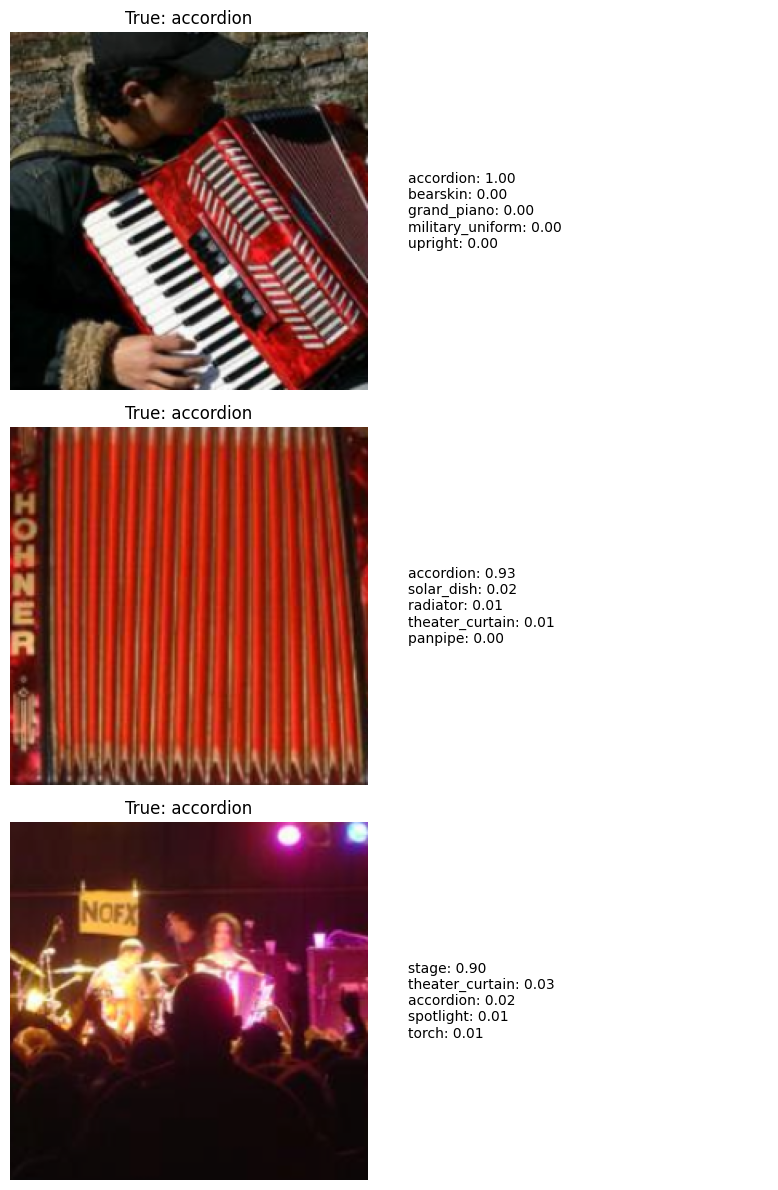


Top 5 easiest classes:
  altar: 100.0%
  ambulance: 100.0%
  apiary: 100.0%
  apron: 100.0%
  assault rifle: 100.0%

Top 5 hardest classes:
  cab: 20.0%
  cassette player: 20.0%
  cello: 20.0%
  church: 20.0%
  bookshop: 0.0%


In [4]:
# Load model & build loader
model_r34    = models.resnet34(weights=weights).to(device)
clean_loader = get_loader(dataset_path)

# Quantitative evaluation
t0 = time.time()
t1_clean, t5_clean = evaluate(model_r34, clean_loader)
print(f"[Task 1] Clean Top-1: {t1_clean:.2f}%, Top-5: {t5_clean:.2f}%  "
      f"(Time: {time.time()-t0:.1f}s)")

# Qualitative examples: first 3 clean images + their Top-5 preds
import torch.nn.functional as F

mean = np.array(transform.mean)
std  = np.array(transform.std)
def denorm(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)*std + mean
    return np.clip(img, 0, 1)

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
cnt = 0
for X, y in clean_loader:
    logits = model_r34(X.to(device))
    probs  = F.softmax(logits, dim=1).cpu()
    top5   = probs.topk(5, dim=1)
    for i in range(X.size(0)):
        # left: image + true label
        axes[cnt,0].imshow(denorm(X[i]))
        axes[cnt,0].axis('off')
        axes[cnt,0].set_title(f"True: {idx100_to_name[y[i].item()]}")
        # right: Top-5 predicted labels + confidences
        inds  = top5.indices[i].tolist()
        vals  = top5.values[i].tolist()
        names = [idx_to_name[p] for p in inds]
        lines = [f"{n}: {v:.2f}" for n, v in zip(names, vals)]
        axes[cnt,1].text(0.05, 0.5, "\n".join(lines),
                         transform=axes[cnt,1].transAxes,
                         fontsize=10, va='center')
        axes[cnt,1].axis('off')
        cnt += 1
        if cnt >= 3:
            break
    if cnt >= 3:
        break

plt.tight_layout()
plt.show()

# Per-class accuracy over the 100-image set
class_correct = {c: 0 for c in idx100_to_name}
class_total   = {c: 0 for c in idx100_to_name}

with torch.no_grad():
    for X, y in clean_loader:
        logits = model_r34(X.to(device))
        preds  = logits.argmax(dim=1).cpu()
        for yi, pi in zip(y, preds):
            class_total[yi.item()]   += 1
            class_correct[yi.item()] += int(pi.item() == yi.item())

acc_per_class = {
    c: class_correct[c] / class_total[c]
    for c in class_total
}

# sort and display top 5 easiest and hardest
sorted_acc = sorted(acc_per_class.items(),
                    key=lambda kv: kv[1],
                    reverse=True)

print("\nTop 5 easiest classes:")
for c, acc in sorted_acc[:5]:
    print(f"  {idx100_to_name[c]}: {acc*100:.1f}%")

print("\nTop 5 hardest classes:")
for c, acc in sorted_acc[-5:]:
    print(f"  {idx100_to_name[c]}: {acc*100:.1f}%")


## Task 2 — FGSM Attack & Evaluation

In this cell we:
1. Build normalized‐space clamping bounds so that we can perturb in pixel space but clamp in normalized space.  
2. Define the `fgsm_attack()` function to perform a single‐step L∞ attack.  
3. Generate the adversarial test set and verify the perturbation budget in pixel space.  
4. Evaluate ResNet-34 on the FGSM set.  
5. Visualize three examples where clean→FGSM flips the prediction.  
6. Plot a histogram of the actual L∞ noise magnitudes.  
7. Show a bar chart comparing clean vs. FGSM accuracy.


Generating FGSM:   0%|          | 0/16 [00:00<?, ?it/s]

[Task 2 FGSM] Top-1: 5.00%, Top-5: 30.20%  (Time: 7.2s)


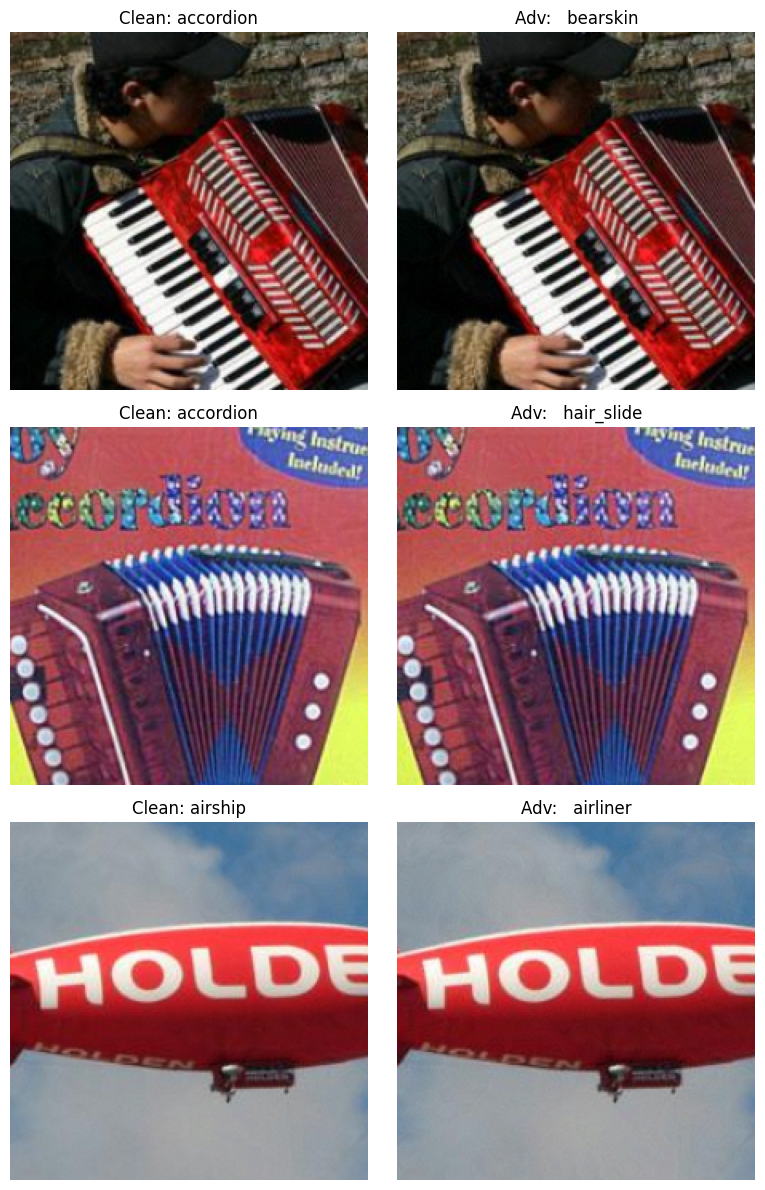

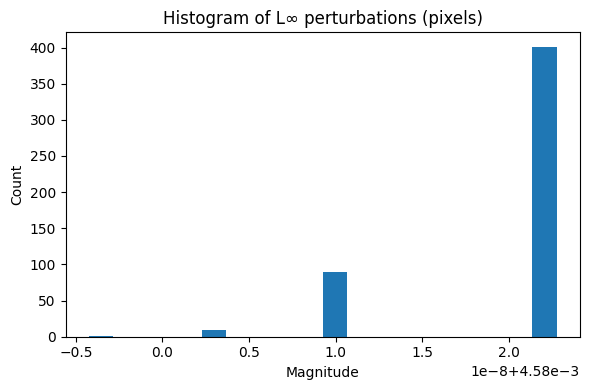

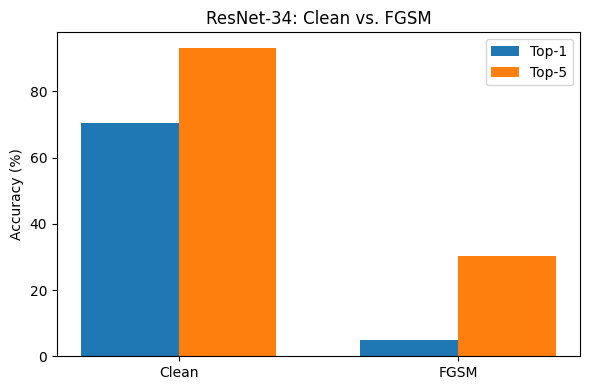

In [5]:
# Build normalized‐space [0,1] bounds for clamping
mean_t   = torch.tensor(transform.mean, device=device).view(1,3,1,1)
std_t    = torch.tensor(transform.std,  device=device).view(1,3,1,1)
clip_min = (0 - mean_t) / std_t
clip_max = (1 - mean_t) / std_t

def fgsm_attack(model, X, y, eps):
    """
    Perform a single-step FGSM attack in normalized space,
    then clamp the result back into the valid normalized range.
    """
    X0    = X.clone().detach().to(device)
    X_adv = X0.clone().detach().requires_grad_(True)
    logits= model(X_adv)
    loss  = F.cross_entropy(logits, y.to(device))
    model.zero_grad(); loss.backward()

    # apply single sign step
    adv = X_adv + eps * X_adv.grad.sign()
    # clamp into normalized bounds [clip_min, clip_max]
    adv = torch.max(torch.min(adv, clip_max), clip_min)
    return adv.detach()

# Gather clean images for budget checking
clean_tensor = torch.cat([X.cpu() for X,_ in clean_loader])

# Generate FGSM adversarial set
t0, adv_imgs, adv_lbls = time.time(), [], []
for X, y in tqdm(clean_loader, desc="Generating FGSM"):
    adv_imgs.append(fgsm_attack(model_r34, X, y, config["epsilon_fgsm"]).cpu())
    adv_lbls.append(y)
adv1_tensor = torch.cat(adv_imgs)
adv1_labels = torch.cat(adv_lbls)

# Budget check (L∞ in pixel domain)
# multiply normalized diff by std to get pixel‐space perturbation
max_pert = ((adv1_tensor - clean_tensor).abs() * std_t.cpu()) \
             .view(clean_tensor.size(0), -1).max(1)[0]
assert (max_pert <= config["epsilon_fgsm"] + 1e-6).all()

# Save & evaluate on FGSM set
os.makedirs("adv_sets", exist_ok=True)
torch.save((adv1_tensor, adv1_labels), "adv_sets/fgsm_eps02.pt")
adv1_loader = DataLoader(
    TensorDataset(adv1_tensor, adv1_labels),
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"]
)
t1_fgsm, t5_fgsm = evaluate(model_r34, adv1_loader)
print(f"[Task 2 FGSM] Top-1: {t1_fgsm:.2f}%, Top-5: {t5_fgsm:.2f}%  (Time: {time.time()-t0:.1f}s)")

# Visualize 3 flipping examples (clean → FGSM)
mean = np.array(transform.mean)
std  = np.array(transform.std)
def denorm(img):
    return np.clip(img.numpy().transpose(1,2,0)*std + mean, 0, 1)

fig, axes = plt.subplots(3, 2, figsize=(8,12))
cnt = 0
for X, y in adv1_loader:
    adv_batch  = fgsm_attack(model_r34, X, y, config["epsilon_fgsm"])
    pred_clean = model_r34(X.to(device)).argmax(dim=1).cpu()
    pred_adv   = model_r34(adv_batch.to(device)).argmax(dim=1).cpu()
    for i in range(X.size(0)):
        if cnt >= 3: break
        if (pred_clean[i] == y[i]) and (pred_adv[i] != y[i]):
            # left: clean image + true label
            axes[cnt,0].imshow(denorm(X[i])); axes[cnt,0].axis('off')
            axes[cnt,0].set_title(f"Clean: {idx100_to_name[y[i].item()]}")
            # right: adversarial image + predicted label
            axes[cnt,1].imshow(denorm(adv_batch[i].cpu())); axes[cnt,1].axis('off')
            axes[cnt,1].set_title(f"Adv:   {idx_to_name[pred_adv[i].item()]}")
            cnt += 1
    if cnt >= 3: break
plt.tight_layout(); plt.show()

# Noise‐magnitude histogram
noise_px = (adv1_tensor - clean_tensor) * std_t.cpu()  # pixel‐space noise
linf     = noise_px.abs().view(noise_px.size(0), -1).max(1)[0]

plt.figure(figsize=(6,4))
plt.hist(linf.numpy(), bins=20)
plt.title("Histogram of L∞ perturbations (pixels)")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Accuracy drop bar chart vs. clean
labels  = ["Clean","FGSM"]
t1_vals = [t1_clean, t1_fgsm]
t5_vals = [t5_clean, t5_fgsm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, t1_vals, width, label="Top-1")
ax.bar(x + width/2, t5_vals, width, label="Top-5")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Accuracy (%)")
ax.set_title("ResNet-34: Clean vs. FGSM")
ax.legend()
plt.tight_layout()
plt.show()

# free up memory
gc.collect()
torch.cuda.empty_cache()


## Task 3 — PGD Attack & Evaluation (with Random Starts & Diagnostics)

This cell implements the multi-step PGD attack with a random initialization and then:

1. **Generates** the adversarial set under the same L∞ budget as FGSM.  
2. **Verifies** the pixel‐domain perturbation budget by converting normalized deltas back to pixel space.  
3. **Evaluates** ResNet-34 on the PGD set.  
4. **Visualizes** three examples where clean → PGD flips the prediction.  
5. **Plots** a histogram of the actual L∞ noise magnitudes.  
6. **Compares** clean vs. PGD accuracy in a bar chart.


PGD:   0%|          | 0/16 [00:00<?, ?it/s]

[Task 3 PGD] Top-1: 0.00%, Top-5: 4.40%  (Time: 29.8s)


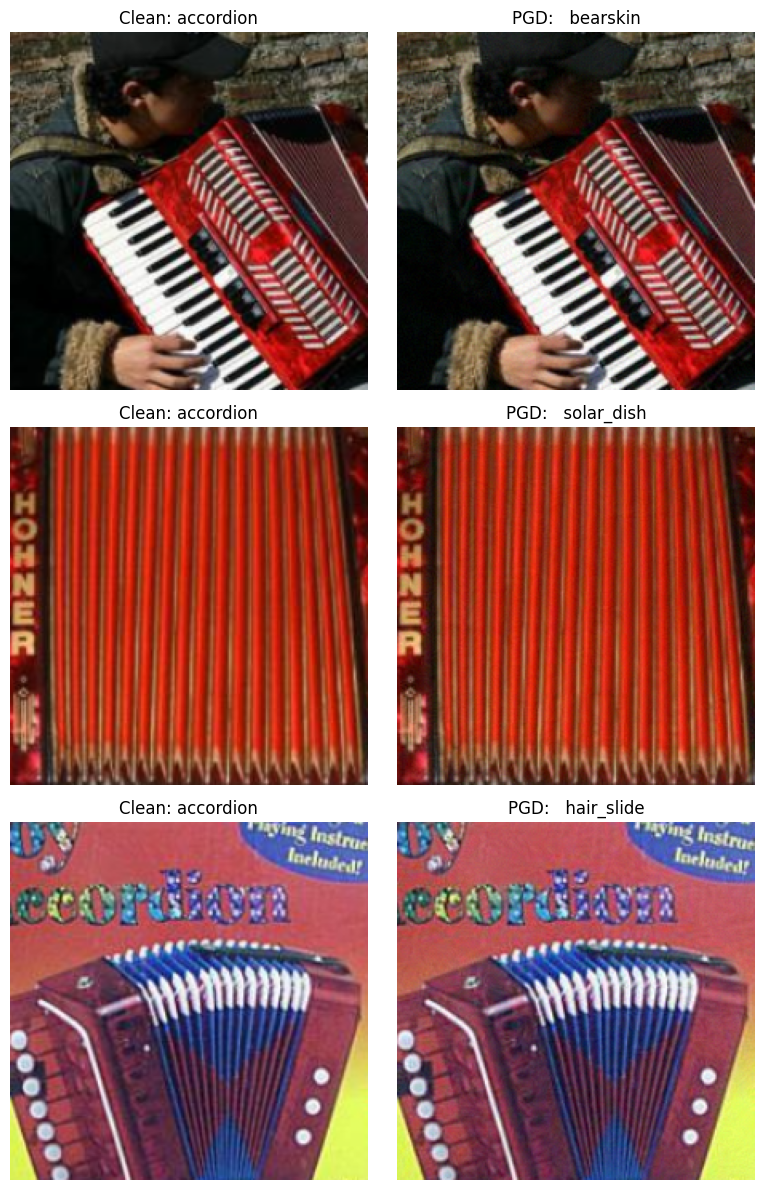

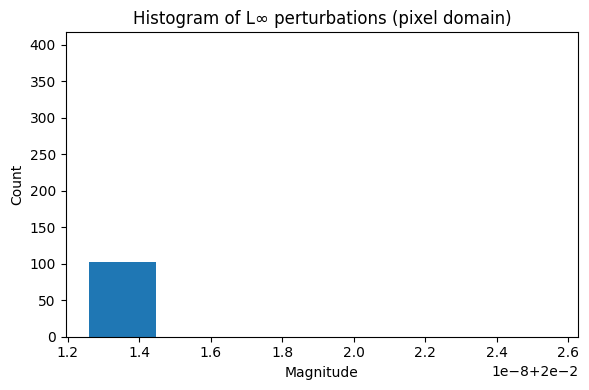

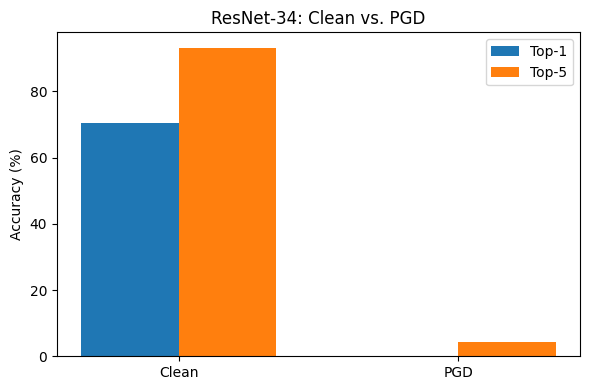

In [6]:
epsn, alph, steps = config["epsilon_fgsm"], config["pgd_alpha"], config["pgd_steps"]
eps_norm = epsn / std_t  # per-channel normalized L∞ radius

def pgd_attack(model, X, y, eps_norm, alpha, steps):
    X0 = X.clone().detach().to(device)
    # random start within normalized L∞ ball
    init_delta = (torch.rand_like(X0) * 2 - 1) * eps_norm
    X_adv = torch.clamp(X0 + init_delta, clip_min, clip_max).detach()

    # iterative gradient steps with projection
    for _ in range(steps):
        X_adv.requires_grad_(True)
        logits = model(X_adv)
        loss   = F.cross_entropy(logits, y.to(device))
        model.zero_grad(); loss.backward()
        grad   = X_adv.grad.sign()

        # gradient step
        X_adv = X_adv + alpha * grad
        # project into L∞ ball around X0
        X_adv = torch.max(torch.min(X_adv, X0 + eps_norm),
                          X0 - eps_norm)
        # clamp back to normalized [0,1] bounds
        X_adv = torch.max(torch.min(X_adv, clip_max),
                          clip_min).detach()

    return X_adv

# Generate the PGD adversarial set
t0 = time.time()
adv2_imgs, adv2_lbls = [], []
for X, y in tqdm(clean_loader, desc="PGD"):
    adv2_imgs.append(pgd_attack(model_r34, X, y, eps_norm, alph, steps).cpu())
    adv2_lbls.append(y)
adv2_tensor = torch.cat(adv2_imgs)
adv2_labels = torch.cat(adv2_lbls)

# Pixel‐domain L∞ budget check
diff_px   = (adv2_tensor - clean_tensor).abs() * std_t.cpu()
max_pert2 = diff_px.view(diff_px.size(0), -1).max(1)[0]
assert (max_pert2 <= epsn + 1e-6).all(), "PGD exceeded L∞ budget!"

# Save & evaluate on PGD set
os.makedirs("adv_sets", exist_ok=True)
torch.save((adv2_tensor, adv2_labels),
           "adv_sets/pgd_eps02_alpha0004_steps10.pt")

adv2_loader = DataLoader(
    TensorDataset(adv2_tensor, adv2_labels),
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)
t1_pgd, t5_pgd = evaluate(model_r34, adv2_loader)
print(f"[Task 3 PGD] Top-1: {t1_pgd:.2f}%, Top-5: {t5_pgd:.2f}%  "
      f"(Time: {time.time()-t0:.1f}s)")

# Visualize 3 flipping examples (clean → PGD)
paired = DataLoader(
    TensorDataset(clean_tensor, adv2_tensor, adv2_labels),
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)
fig, axes = plt.subplots(3, 2, figsize=(8,12))
cnt = 0
for Xc, Xa, y in paired:
    p_c = model_r34(Xc.to(device)).argmax(1).cpu()
    p_a = model_r34(Xa.to(device)).argmax(1).cpu()
    for i in range(Xc.size(0)):
        if cnt >= 3: break
        if (p_c[i] == y[i]) and (p_a[i] != y[i]):
            axes[cnt,0].imshow(denorm(Xc[i])); axes[cnt,0].axis('off')
            axes[cnt,0].set_title(f"Clean: {idx100_to_name[y[i].item()]}")
            axes[cnt,1].imshow(denorm(Xa[i])); axes[cnt,1].axis('off')
            axes[cnt,1].set_title(f"PGD:   {idx_to_name[p_a[i].item()]}")
            cnt += 1
    if cnt >= 3: break
plt.tight_layout(); plt.show()

# Histogram of L∞ perturbations (pixel domain)
linf2 = max_pert2.numpy()
plt.figure(figsize=(6,4))
plt.hist(linf2, bins=20)
plt.title("Histogram of L∞ perturbations (pixel domain)")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Accuracy drop bar chart vs. Clean
labels  = ["Clean", "PGD"]
t1_vals = [t1_clean, t1_pgd]
t5_vals = [t5_clean, t5_pgd]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, t1_vals, width, label="Top-1")
ax.bar(x + width/2, t5_vals, width, label="Top-5")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Accuracy (%)")
ax.set_title("ResNet-34: Clean vs. PGD")
ax.legend()
plt.tight_layout()
plt.show()

# Free memory
gc.collect()
torch.cuda.empty_cache()


## Task 4 — Patch Attack & Diagnostics

In this cell we:

1. **Precompute** normalized‐space bounds for our patch attack.  
2. **Define** `patch_attack(...)` which perturbs only a single square patch per image in normalized space, enforcing both L₀ (patch size) and L∞ (ε) constraints. We also store the last mask for visualization.  
3. **Generate** the full patched test set and check:
   - Approximate L₀ constraint (only the patch moved).  
   - Pixel‐domain L∞ constraint (perturbations respect ε in the original pixel range).  
4. **Save** the adversarial set.  
5. **Evaluate** ResNet‐34 accuracy on the patched set.  
6. **Visualize** three examples where the clean image was correctly classified but the patch flips the prediction.  
7. **Plot** a histogram of the L∞ perturbations in pixel space.  
8. **Show** an accuracy‐drop bar chart comparing clean vs. patch performance.  
9. **Overlay** the learned patch mask for one example.  


Patch:   0%|          | 0/16 [00:00<?, ?it/s]

[Task 4 Patch] Top-1: 19.60%, Top-5: 58.00%  (Time: 31.1s)


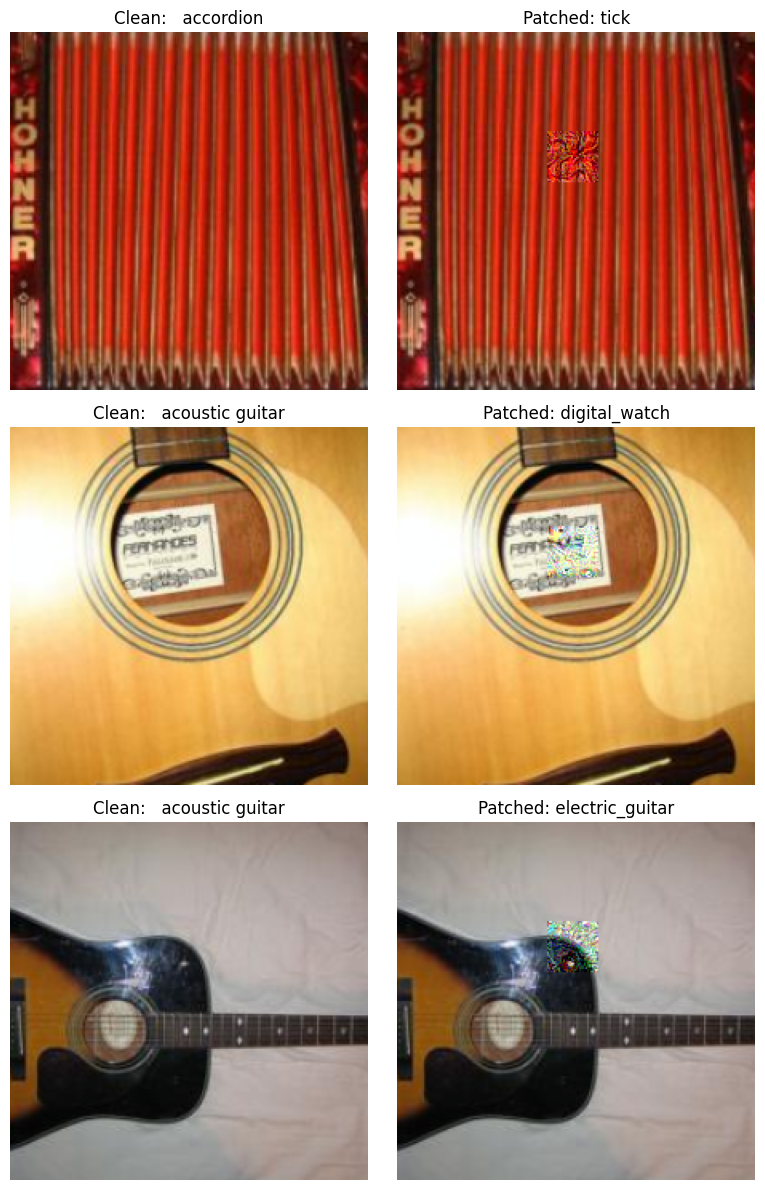

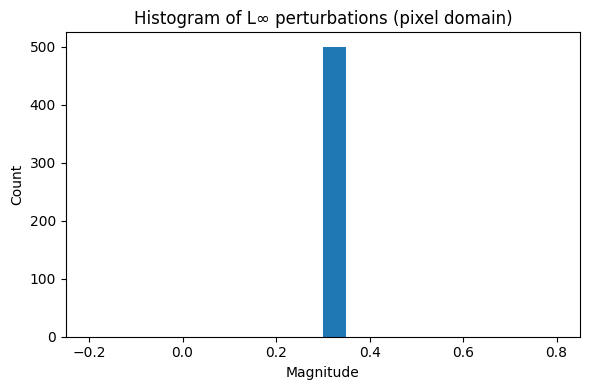

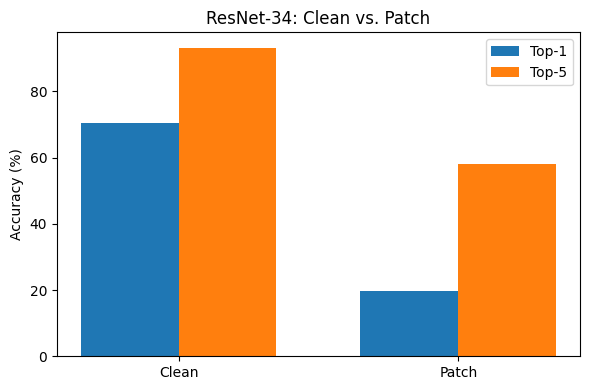

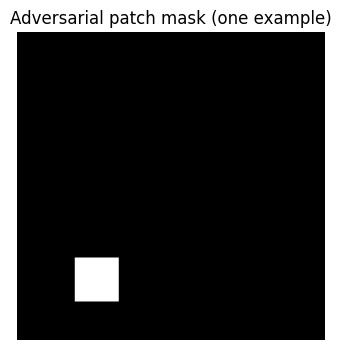

In [7]:
# --- precompute normalized‐space patch bounds ---
eps_patch     = config["patch_eps"]               # pixel‐space L∞ radius
alpha_patch   = eps_patch / 5                     # pixel‐space step size
eps_patch_n   = eps_patch / std_t                  # per‐channel normalized radius
alpha_patch_n = alpha_patch / std_t                # per‐channel normalized step

def patch_attack(model, X, y, patch_size, eps_n, alpha_n, steps):
    """
    Perform a patch‐only adversarial attack in normalized space.
    Only a single square patch of size patch_size×patch_size
    is modified, with per-channel L∞ ≤ eps_n.
    """
    X0    = X.clone().detach().to(device)   # normalized originals
    X_adv = X0.clone().detach()
    B, C, H, W = X0.shape

    # pick one random patch location (same for entire batch)
    top  = np.random.randint(0, H - patch_size + 1)
    left = np.random.randint(0, W - patch_size + 1)

    # build a binary mask for that patch
    mask = torch.zeros_like(X0)
    mask[:, :, top:top+patch_size, left:left+patch_size] = 1.0

    # store the last mask for visualization
    patch_attack.last_mask = mask[0].cpu()

    for _ in range(steps):
        X_adv.requires_grad_(True)
        logits = model(X_adv)
        loss   = F.cross_entropy(logits, y.to(device))
        model.zero_grad(); loss.backward()
        grad = X_adv.grad.sign()

        # gradient step only inside patch
        X_adv = X_adv + alpha_n * (grad * mask)

        # project patch‐difference back into [-eps_n, +eps_n]
        delta = X_adv - X0
        delta = torch.clamp(delta, -eps_n, +eps_n) * mask

        # reconstruct adversarial and detach
        X_adv = (X0 + delta).detach()

    return X_adv

# Generate the full patched set
t0 = time.time()
adv3_list, lbl3_list = [], []
for X, y in tqdm(clean_loader, desc="Patch"):
    adv3 = patch_attack(
        model_r34, X, y,
        config["patch_size"],
        eps_patch_n,
        alpha_patch_n,
        config["pgd_steps"]
    )
    adv3_list.append(adv3.cpu())
    lbl3_list.append(y)
adv3_tensor = torch.cat(adv3_list)
adv3_labels = torch.cat(lbl3_list)

# Approximate L₀ check (only patch moved)
l0 = (adv3_tensor - clean_tensor).abs().gt(1e-6) \
         .view(clean_tensor.size(0), -1).sum(1)
max_allowed = config["patch_size"]**2 * 3
assert (l0 <= max_allowed).all(), \
       f"Too many pixels changed ({int(l0.max())} > {max_allowed})"

# Pixel‐domain L∞ budget check
diff_px   = (adv3_tensor - clean_tensor).abs() * std_t.cpu()
max_pert3 = diff_px.view(diff_px.size(0), -1).max(1)[0]
assert (max_pert3 <= config["patch_eps"] + 1e-6).all(), \
       "Patch exceeded L∞ budget in pixel space!"

# Save & evaluate
os.makedirs("adv_sets", exist_ok=True)
torch.save((adv3_tensor, adv3_labels), "adv_sets/patch32_eps03.pt")

adv3_loader = DataLoader(
    TensorDataset(adv3_tensor, adv3_labels),
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)
t1_patch, t5_patch = evaluate(model_r34, adv3_loader)
print(f"[Task 4 Patch] Top-1: {t1_patch:.2f}%, Top-5: {t5_patch:.2f}%  "
      f"(Time: {time.time() - t0:.1f}s)")

# Visualize 3 failures (clean → patched)
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
cnt = 0
for (X_adv, y), (X_clean, _) in zip(adv3_loader, clean_loader):
    p_clean = model_r34(X_clean.to(device)).argmax(1).cpu()
    p_patch = model_r34(X_adv.to(device)).argmax(1).cpu()
    for i in range(X_adv.size(0)):
        if cnt >= 3: break
        if (p_clean[i] == y[i]) and (p_patch[i] != y[i]):
            axes[cnt,0].imshow(denorm(X_clean[i])); axes[cnt,0].axis("off")
            axes[cnt,0].set_title(f"Clean:   {idx100_to_name[y[i].item()]}")
            axes[cnt,1].imshow(denorm(X_adv[i]));   axes[cnt,1].axis("off")
            axes[cnt,1].set_title(f"Patched: {idx_to_name[p_patch[i].item()]}")
            cnt += 1
    if cnt >= 3: break
plt.tight_layout(); plt.show()

# Histogram of L∞ perturbations (pixels)
plt.figure(figsize=(6,4))
plt.hist(max_pert3.numpy(), bins=20)
plt.title("Histogram of L∞ perturbations (pixel domain)")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Accuracy drop bar chart vs. Clean
labels   = ["Clean","Patch"]
t1_vals  = [t1_clean, t1_patch]
t5_vals  = [t5_clean, t5_patch]
x = np.arange(len(labels)); width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, t1_vals, width, label="Top-1")
ax.bar(x + width/2, t5_vals, width, label="Top-5")
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel("Accuracy (%)")
ax.set_title("ResNet-34: Clean vs. Patch")
ax.legend(); plt.tight_layout(); plt.show()

# Overlay the learned patch mask
mask_np = patch_attack.last_mask.numpy().transpose(1,2,0)
plt.figure(figsize=(4,4))
plt.imshow(mask_np[:,:,0], cmap="gray")
plt.title("Adversarial patch mask (one example)")
plt.axis("off"); plt.show()

gc.collect(); torch.cuda.empty_cache()


## Regenerate PGD Set for DenseNet Transfer

Here we use a separate PGD budget (`pgd_eps_dn`, `pgd_alpha_dn`) tuned for transfer experiments. We generate a fresh adversarial set (with random starts) from ResNet-34 under this new budget, to evaluate how well these attacks transfer to DenseNet-121.


In [8]:
# normalized-space budgets for DenseNet transfer
epsn_dn  = config["pgd_eps_dn"]   / std_t        # per-channel normalized L∞ radius
alpha_dn = config["pgd_alpha_dn"] / std_t        # per-channel normalized step size

adv2_dn_imgs, adv2_dn_lbls = [], []
for X, y in tqdm(clean_loader, desc="PGD for DenseNet"):
    # reuse our pgd_attack with the new budgets
    adv_dn = pgd_attack(model_r34, X, y, epsn_dn, alpha_dn, config["pgd_steps"])
    adv2_dn_imgs.append(adv_dn.cpu())
    adv2_dn_lbls.append(y)

adv2_dn_tensor = torch.cat(adv2_dn_imgs)
adv2_dn_labels = torch.cat(adv2_dn_lbls)

adv2_dn_loader = DataLoader(
    TensorDataset(adv2_dn_tensor, adv2_dn_labels),
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"]
)


PGD for DenseNet:   0%|          | 0/16 [00:00<?, ?it/s]

## Task 5 — Transferability to DenseNet-121

This cell evaluates how well the adversarial examples generated on ResNet-34 transfer to a different architecture (DenseNet-121). We compute Top-1 and Top-5 accuracies on the clean, FGSM, PGD (tuned for DenseNet), and patch-attacked sets; save the results to CSV; and visualize them in a bar chart.


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 135MB/s] 


[Transfer → DenseNet] Clean  | Top-1: 70.80%, Top-5: 91.20%  (Time: 3.6s)
[Transfer → DenseNet] FGSM   | Top-1: 59.00%, Top-5: 85.00%  (Time: 1.7s)
[Transfer → DenseNet] PGD    | Top-1: 39.20%, Top-5: 75.00%  (Time: 1.6s)
[Transfer → DenseNet] Patch  | Top-1: 64.20%, Top-5: 88.60%  (Time: 1.7s)

Transfer results saved to transfer_results.csv


Set  Top-1  Top-5
0  Clean   70.8   91.2
1   FGSM   59.0   85.0
2    PGD   39.2   75.0
3  Patch   64.2   88.6

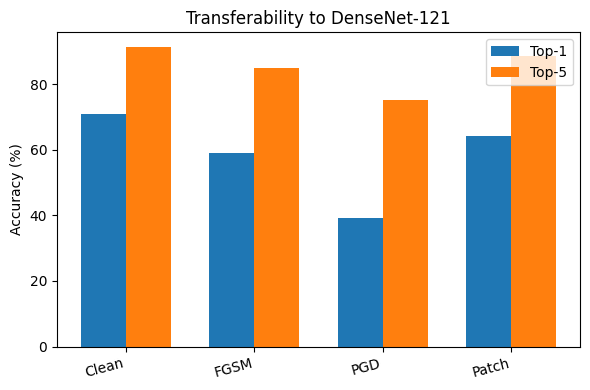

In [9]:
import pandas as pd

# Load DenseNet-121
model_dn = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)

# Evaluate on each set
transfer_results = []
for name, loader in [
    ("Clean", clean_loader),
    ("FGSM",  adv1_loader),
    ("PGD",   adv2_dn_loader),  # PGD set tuned for DenseNet
    ("Patch", adv3_loader),
]:
    t0 = time.time()
    t1, t5 = evaluate(model_dn, loader)
    print(f"[Transfer → DenseNet] {name:6s} | Top-1: {t1:.2f}%, Top-5: {t5:.2f}%  "
          f"(Time: {time.time()-t0:.1f}s)")
    transfer_results.append((name, t1, t5))

# Save results and display as DataFrame
df_transfer = pd.DataFrame(transfer_results, columns=["Set", "Top-1", "Top-5"])
df_transfer.to_csv("transfer_results.csv", index=False)
print("\nTransfer results saved to transfer_results.csv")
display(df_transfer)

# Bar chart of DenseNet-121 accuracy across sets
plt.figure(figsize=(6,4))
x = np.arange(len(df_transfer))
width = 0.35
plt.bar(x - width/2, df_transfer["Top-1"], width, label="Top-1")
plt.bar(x + width/2, df_transfer["Top-5"], width, label="Top-5")
plt.xticks(x, df_transfer["Set"], rotation=15, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Transferability to DenseNet-121")
plt.legend()
plt.tight_layout()
plt.show()

# Cleanup
gc.collect()
torch.cuda.empty_cache()


## Summary Table & Save Final Results

This cell compiles all the Top-1 and Top-5 accuracies for both ResNet-34 and DenseNet-121 across the clean and adversarial test sets into a single summary table, saves it to CSV, and displays it for easy reference.


In [10]:
import pandas as pd

# Collect ResNet-34 results
rows = [
    ("ResNet-34 Clean",   t1_clean,  t5_clean),
    ("ResNet-34 FGSM",    t1_fgsm,   t5_fgsm),
    ("ResNet-34 PGD",     t1_pgd,    t5_pgd),
    ("ResNet-34 Patch",   t1_patch,  t5_patch),
]

# Append DenseNet-121 transfer results
for prefix, t1, t5 in transfer_results:
    rows.append((f"DenseNet-121 {prefix}", t1, t5))

# Build DataFrame and save
df_summary = pd.DataFrame(rows, columns=["Model/Set", "Top-1", "Top-5"])
df_summary.to_csv("results_summary.csv", index=False)

# Display the summary table
display(df_summary)


Model/Set  Top-1  Top-5
0     ResNet-34 Clean   70.4   93.2
1      ResNet-34 FGSM    5.0   30.2
2       ResNet-34 PGD    0.0    4.4
3     ResNet-34 Patch   19.6   58.0
4  DenseNet-121 Clean   70.8   91.2
5   DenseNet-121 FGSM   59.0   85.0
6    DenseNet-121 PGD   39.2   75.0
7  DenseNet-121 Patch   64.2   88.6

## Grouped Bar Chart of Top-1 vs Top-5 Accuracies

This cell visualizes the final summary table (from Cell 9) as a grouped bar chart, comparing Top-1 and Top-5 accuracies across all test sets for both ResNet-34 and DenseNet-121.


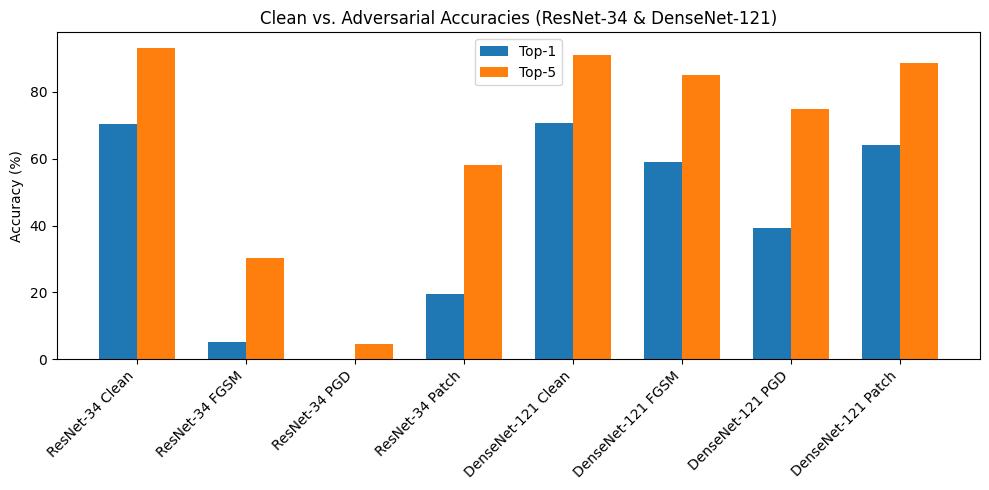

In [11]:
# Cell 10: Grouped bar chart of Top-1 vs Top-5 for both models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload the summary table from disk
df = pd.read_csv("results_summary.csv")

plt.figure(figsize=(10,5))
labels = df["Model/Set"].tolist()
x      = np.arange(len(labels))
w      = 0.35

plt.bar(x - w/2, df["Top-1"], w, label="Top-1")
plt.bar(x + w/2, df["Top-5"], w, label="Top-5")

plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Clean vs. Adversarial Accuracies (ResNet-34 & DenseNet-121)")
plt.legend()
plt.tight_layout()
plt.show()
